Training Kennedy jointly

In [9]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
tf.keras.backend.set_floatx('float32')
from collections import deque
from datetime import datetime
import random
import matplotlib
from environment import Environment
from plots import just_plot, profiles_kennedy
import misc 
import nets
from buffer import ReplayBuffer
from datetime import datetime


In [16]:
amplitude=0.4
lr_critic = 0.01
lr_actor = 0.005
ep_guess=1
dolinar_layers=1
number_phases=2
buffer_size = 10**6
tau = 0.05
batch_size=64


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = nets.Critic(nature="primary", dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = nets.Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = nets.Actor(nature="primary", dolinar_layers = dolinar_layers)
actor_target = nets.Actor(nature="target", dolinar_layers = dolinar_layers, tau = tau)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)

policy_evaluator = misc.PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)


kk = np.load("buffers/1L_prob.npy")
for k in kk:
    buffer.add(tuple(k))
    
total_episodes = 10**4
evolution_loss=[]
history_predictions={"final_episode_info":total_episodes}
bbbs = np.arange(0,2.05,.05)
inps = np.stack([np.ones(len(bbbs))*critic.pad_value, bbbs], axis=1)
inps = np.reshape(inps, (len(bbbs),1,2))

betas_would=[]
for iteration in tqdm(range(total_episodes)):

    sampled_dataset = buffer.sample(batch_size).astype(np.float32)
    batched_sampled_dataset, rews_per_layer = critic.process_sequence_tf(sampled_dataset)
    td_errors = critic_target.give_td_errors_tf(batched_sampled_dataset, rews_per_layer)
    loss = critic.step_critic_tf(batched_sampled_dataset, td_errors, optimizer_critic)
    evolution_loss.append(loss.numpy())
    critic_target.update_target_parameters(critic)
    actored_experiences = actor.process_sequence_of_experiences_tf(sampled_dataset)
    dq_da = critic.critic_grad_tf(actored_experiences)[0]
    actor.actor_grad_tf(dq_da, sampled_dataset, optimizer_actor)
    betas_would.append(actor(tf.random.uniform((batch_size,1,1)))[0])
    if iteration%(int(total_episodes/5)) == 0:
        history_predictions[str(iteration)] = {"[]":[], "00":[],"01":[],"11":[],"10":[]}
        history_predictions[str(iteration)]["[]"] = np.squeeze(critic(inps))
        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                history_predictions[str(iteration)][str(outcome)+str(guess_index)] = np.squeeze(critic(tf.stack(m, axis=0)))[:,1]

In [19]:
def profiles_kennedy(critic, history_predictions, bbs):
    matplotlib.rc('font', serif='cm10')
    plt.rcParams.update({'font.size': 100})
    plt.figure(figsize=(150,150), dpi=50)


    ax1 = plt.subplot2grid((2,2),(0,0))
    ax2 = plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
    #betas = np.arange(.1,1.1,.05)
    betas = bbs
    if history_predictions!=False:
        axs = {"0":ax1, "1":ax2}
        for ind, epi in enumerate(history_predictions.keys()):
            if epi != "final_episode_info":

                transp_epi = float(epi)/history_predictions["final_episode_info"]
                ax3.plot(betas,history_predictions[epi]["[]"] , alpha=transp_epi, linewidth=3,label=str(epi))
                for outcome in [0.,1.]:
                   for guess_index in [0.,1.]:
                       axs[str(int(outcome))].plot(betas, history_predictions[epi][str(outcome)+str(guess_index)] , alpha=transp_epi, linewidth=3,label=str(epi))#+"-g:"+str((-1)**guess_index))



    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), '--', color="black", linewidth=10,label="RNN")

    axes = {"0.0":ax1, "1.0":ax2}
    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], '--', color="black", linewidth=10,label="RNN")


    ax1.plot(betas,[misc.qval(b, 0, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[misc.qval(b, 0, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[misc.qval(b, 1, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[misc.qval(b, 1, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,misc.ps_maxlik(betas), linewidth=7, color="red", label="P*")

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})



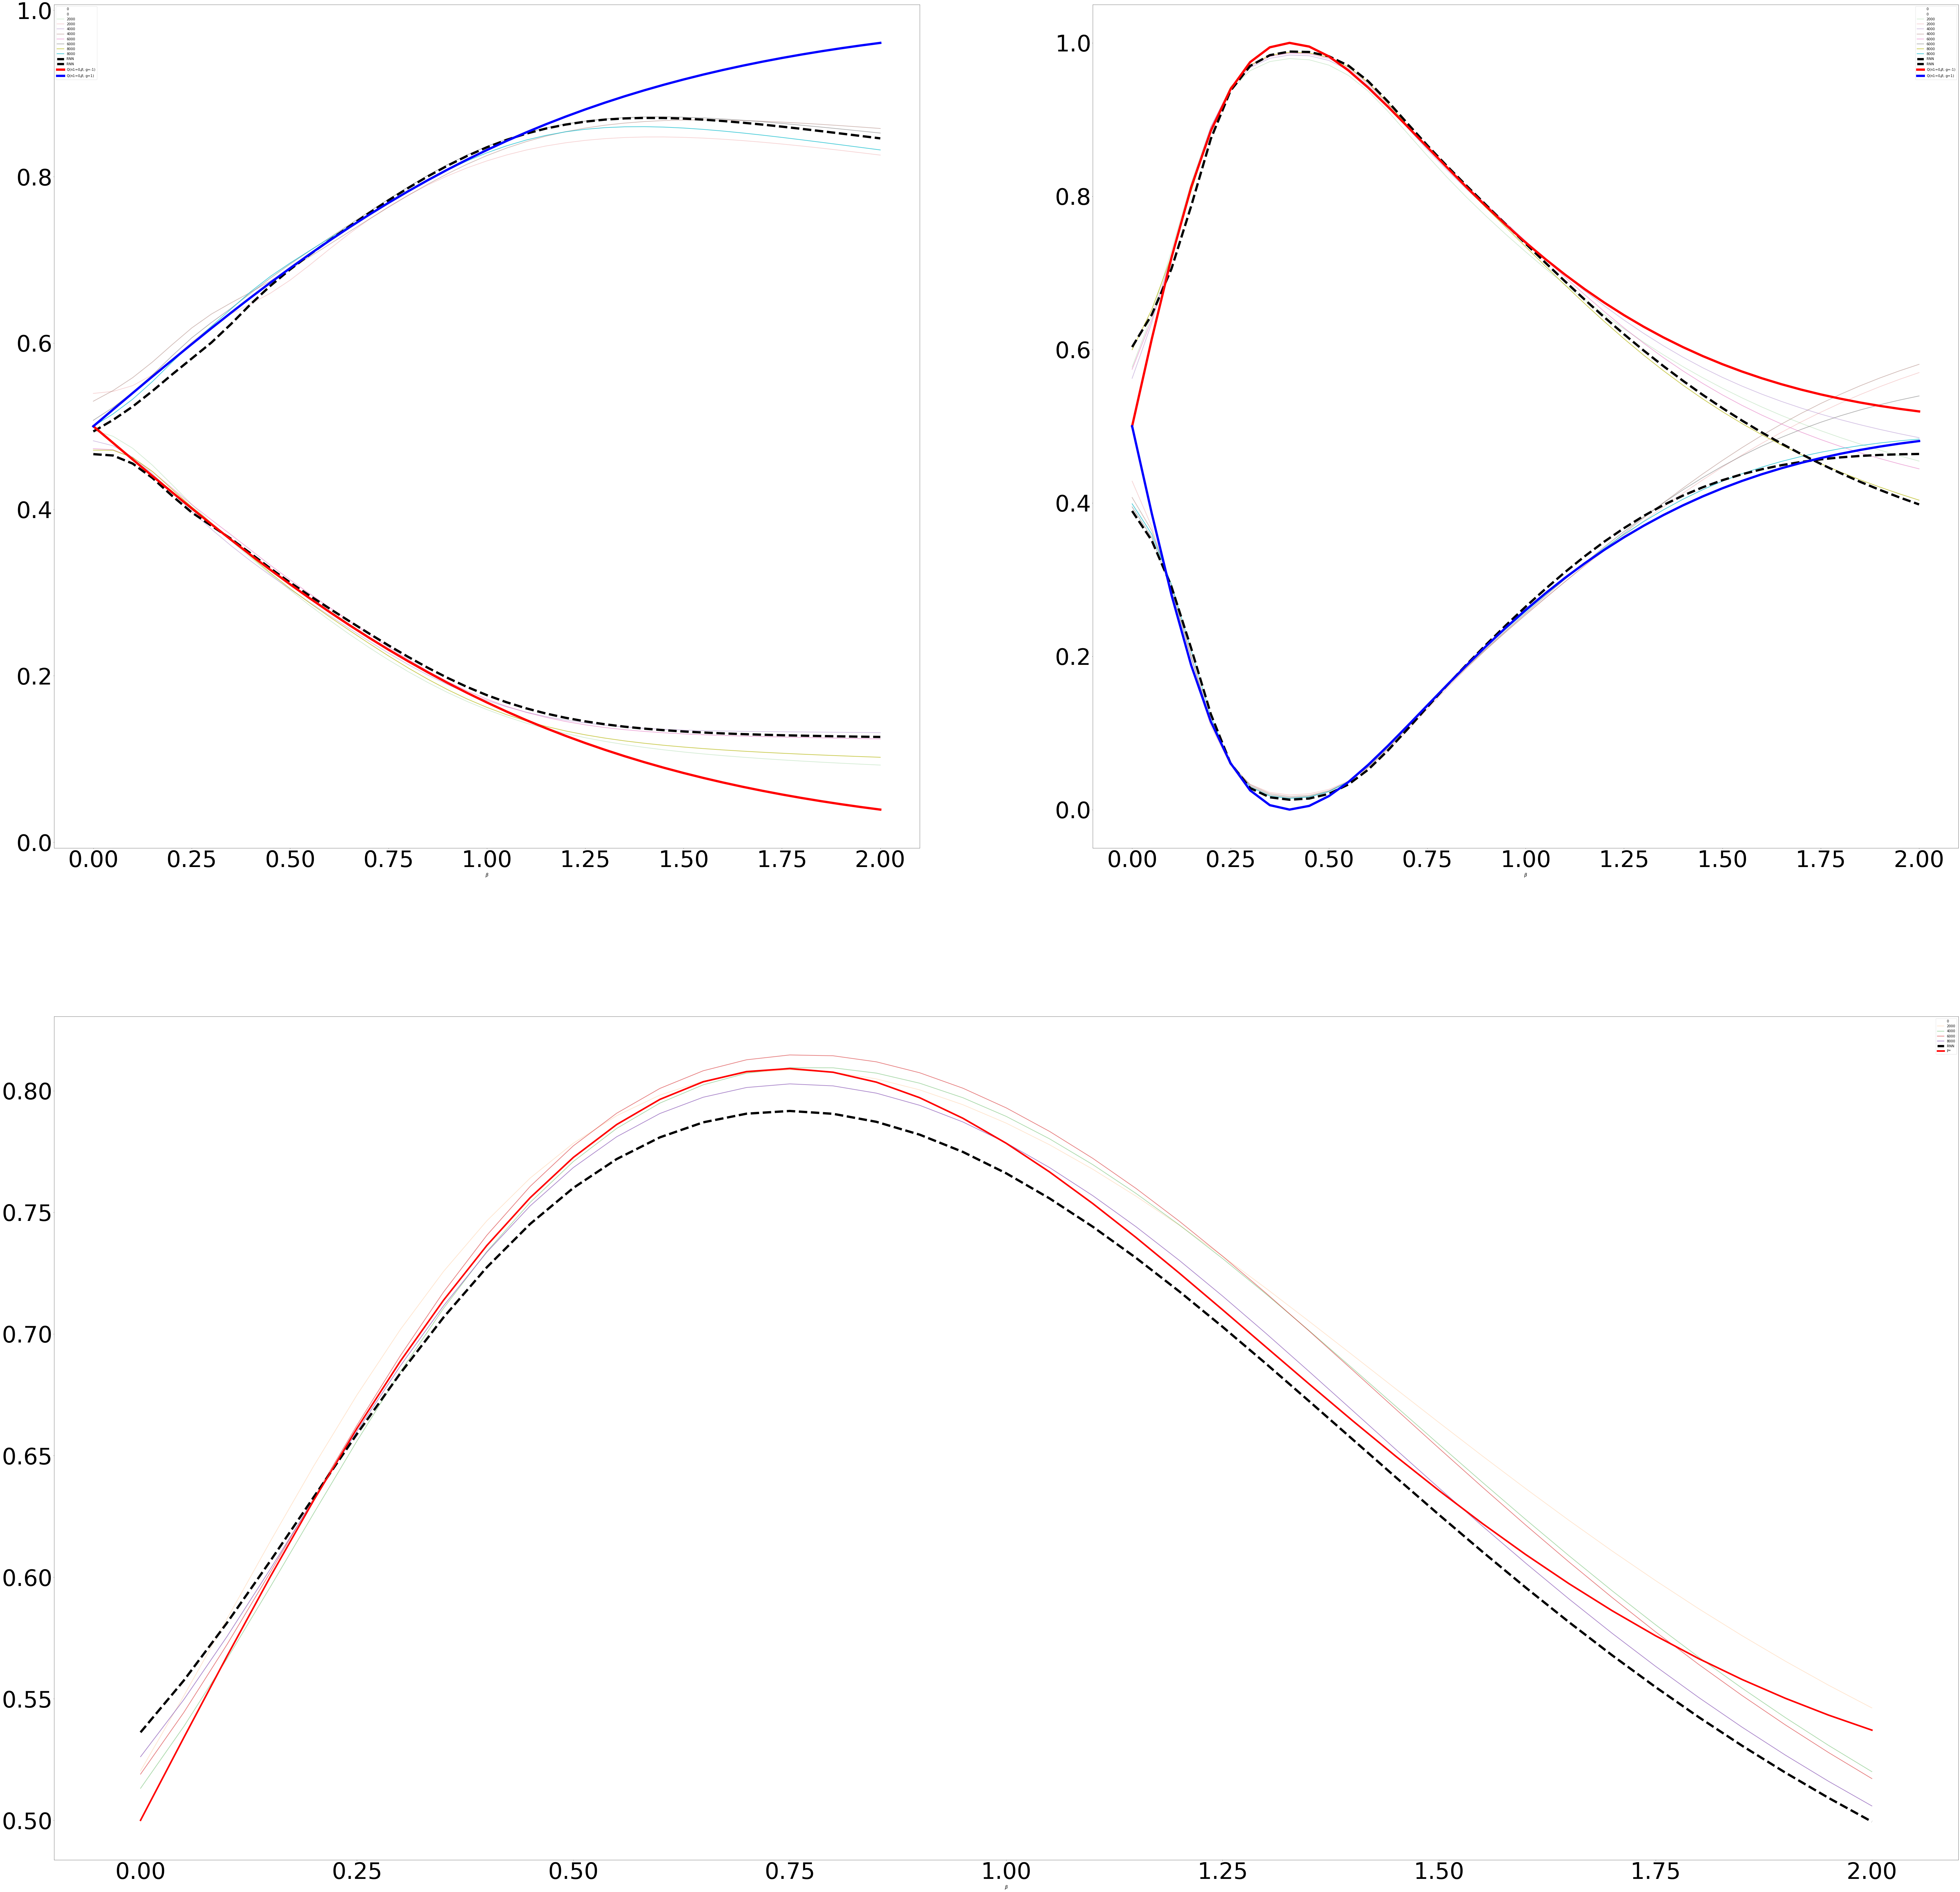

In [20]:
profiles_kennedy(critic, history_predictions,bbbs)

In [28]:
amplitude=0.4
lr_critic = 0.01
lr_actor = 0.005
ep_guess=1
dolinar_layers=1
number_phases=2
buffer_size = 10**6
tau = 0.05
batch_size=64


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = nets.Critic(nature="primary", dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = nets.Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = nets.Actor(nature="primary", dolinar_layers = dolinar_layers)
actor_target = nets.Actor(nature="target", dolinar_layers = dolinar_layers, tau = tau)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)

policy_evaluator = misc.PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)


kk = np.load("buffers/1L_prob.npy")
for k in kk:
    buffer.add(tuple(k))
    
total_episodes = 10**3
evolution_loss=[]
history_predictions={"final_episode_info":total_episodes}
bbbs = np.arange(0,2.05,.05)
inps = np.stack([np.ones(len(bbbs))*critic.pad_value, bbbs], axis=1)
inps = np.reshape(inps, (len(bbbs),1,2))

betas_would=[]
for iteration in tqdm(range(total_episodes)):

    sampled_dataset = buffer.sample(batch_size).astype(np.float32)
    batched_sampled_dataset, rews_per_layer = critic.process_sequence_tf(sampled_dataset)
    td_errors = critic_target.give_td_errors_tf(batched_sampled_dataset, rews_per_layer)
    loss = critic.step_critic_tf(batched_sampled_dataset, td_errors, optimizer_critic)
    evolution_loss.append(loss.numpy())
    critic_target.update_target_parameters(critic)
    actored_experiences = actor.process_sequence_of_experiences_tf(sampled_dataset)
    dq_da = critic.critic_grad_tf(actored_experiences)[0]
    actor.actor_grad_tf(dq_da, sampled_dataset, optimizer_actor)
    betas_would.append(np.squeeze(actor(tf.random.uniform((batch_size,1,1))))[0])
    if iteration%(int(total_episodes/5)) == 0:
        history_predictions[str(iteration)] = {"[]":[], "00":[],"01":[],"11":[],"10":[]}
        history_predictions[str(iteration)]["[]"] = np.squeeze(critic(inps))
        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                history_predictions[str(iteration)][str(outcome)+str(guess_index)] = np.squeeze(critic(tf.stack(m, axis=0)))[:,1]
profiles_kennedy(critic, history_predictions,bbbs)

  0%|          | 0/1000 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 1000/1000 [00:34<00:00, 29.23it/s]


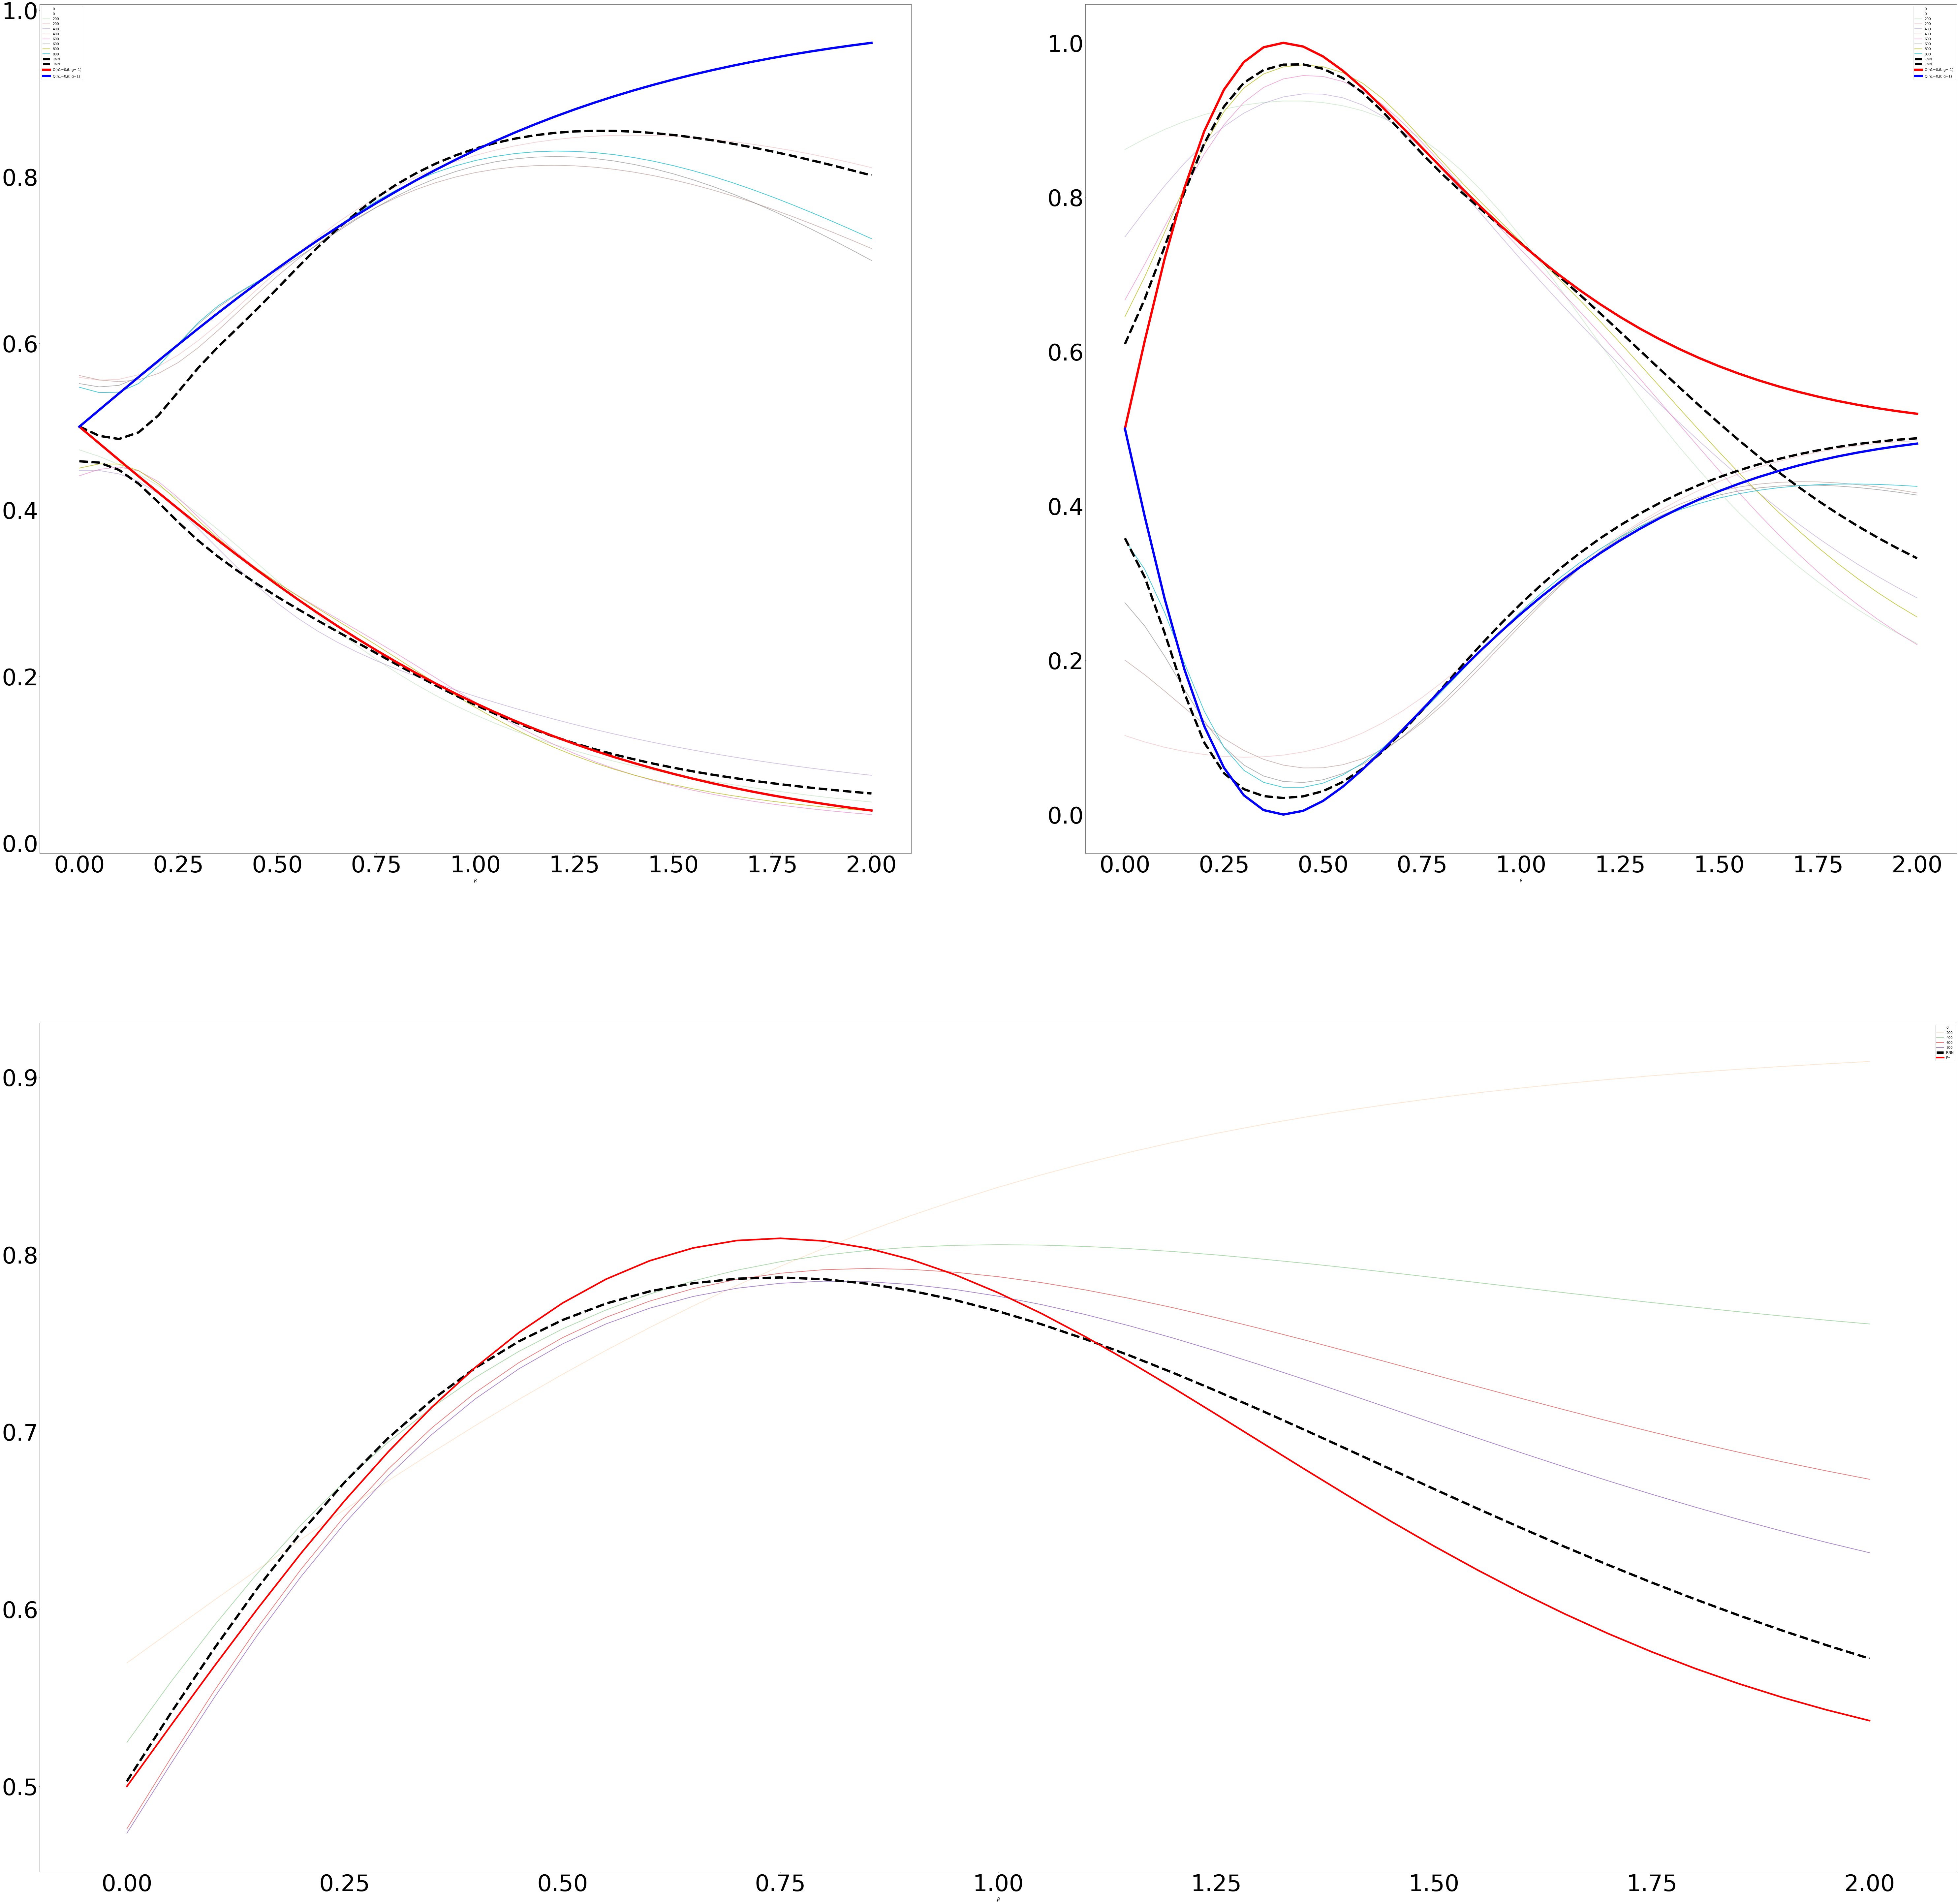

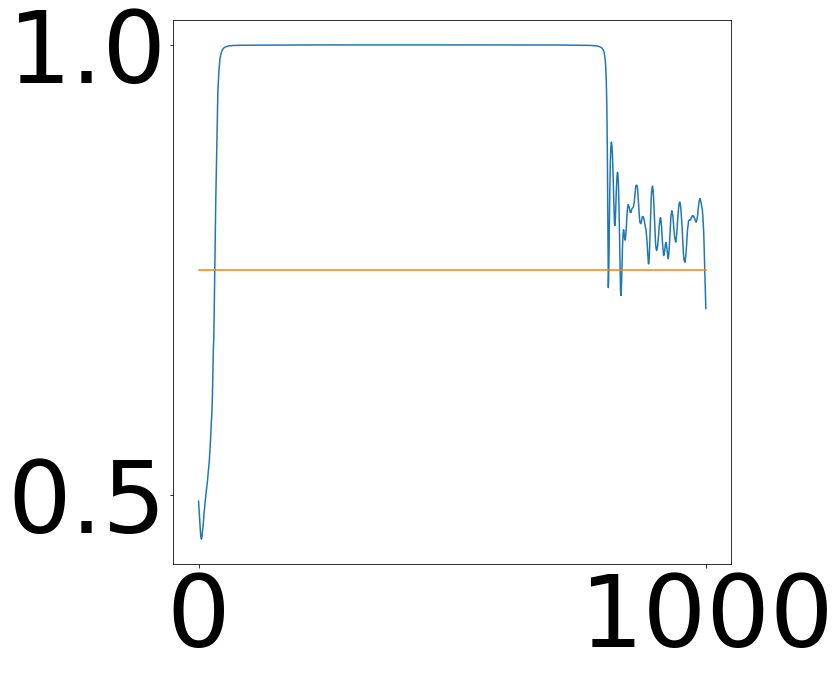

In [34]:
optimal_beta= 0.7499999999999993

plt.figure(figsize=(10,10))
plt.plot(betas_would)
plt.plot(np.ones(len(betas_would))*optimal_beta)

OKKK... let's see with the rewards...

In [36]:
amplitude=0.4
lr_critic = 0.01
lr_actor = 0.005
ep_guess=1
dolinar_layers=1
number_phases=2
buffer_size = 10**6
tau = 0.05
batch_size=64


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = nets.Critic(nature="primary", dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = nets.Critic(nature="target", dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = nets.Actor(nature="primary", dolinar_layers = dolinar_layers)
actor_target = nets.Actor(nature="target", dolinar_layers = dolinar_layers, tau = tau)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.Adam(lr=lr_actor)

policy_evaluator = misc.PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)


kk = np.load("buffers/1L-stoch.npy")
for k in kk:
    buffer.add(tuple(k))
    
total_episodes = 5*10**3
evolution_loss=[]
history_predictions={"final_episode_info":total_episodes}
jj = buffer.sample(buffer.count)[:,0]
bbbs = np.arange(min(jj),max(jj),.05)
inps = np.stack([np.ones(len(bbbs))*critic.pad_value, bbbs], axis=1)
inps = np.reshape(inps, (len(bbbs),1,2))

betas_would=[]
for iteration in tqdm(range(total_episodes)):

    sampled_dataset = buffer.sample(batch_size).astype(np.float32)
    batched_sampled_dataset, rews_per_layer = critic.process_sequence_tf(sampled_dataset)
    td_errors = critic_target.give_td_errors_tf(batched_sampled_dataset, rews_per_layer)
    loss = critic.step_critic_tf(batched_sampled_dataset, td_errors, optimizer_critic)
    evolution_loss.append(loss.numpy())
    critic_target.update_target_parameters(critic)
    actored_experiences = actor.process_sequence_of_experiences_tf(sampled_dataset)
    dq_da = critic.critic_grad_tf(actored_experiences)[0]
    actor.actor_grad_tf(dq_da, sampled_dataset, optimizer_actor)
    betas_would.append(np.squeeze(actor(tf.random.uniform((batch_size,1,1))))[0])
    if iteration%(int(total_episodes/5)) == 0:
        history_predictions[str(iteration)] = {"[]":[], "00":[],"01":[],"11":[],"10":[]}
        history_predictions[str(iteration)]["[]"] = np.squeeze(critic(inps))
        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                history_predictions[str(iteration)][str(outcome)+str(guess_index)] = np.squeeze(critic(tf.stack(m, axis=0)))[:,1]


  0%|          | 0/5000 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 5000/5000 [02:13<00:00, 37.43it/s]


NameError: name 'profiles_and_kennedy' is not defined

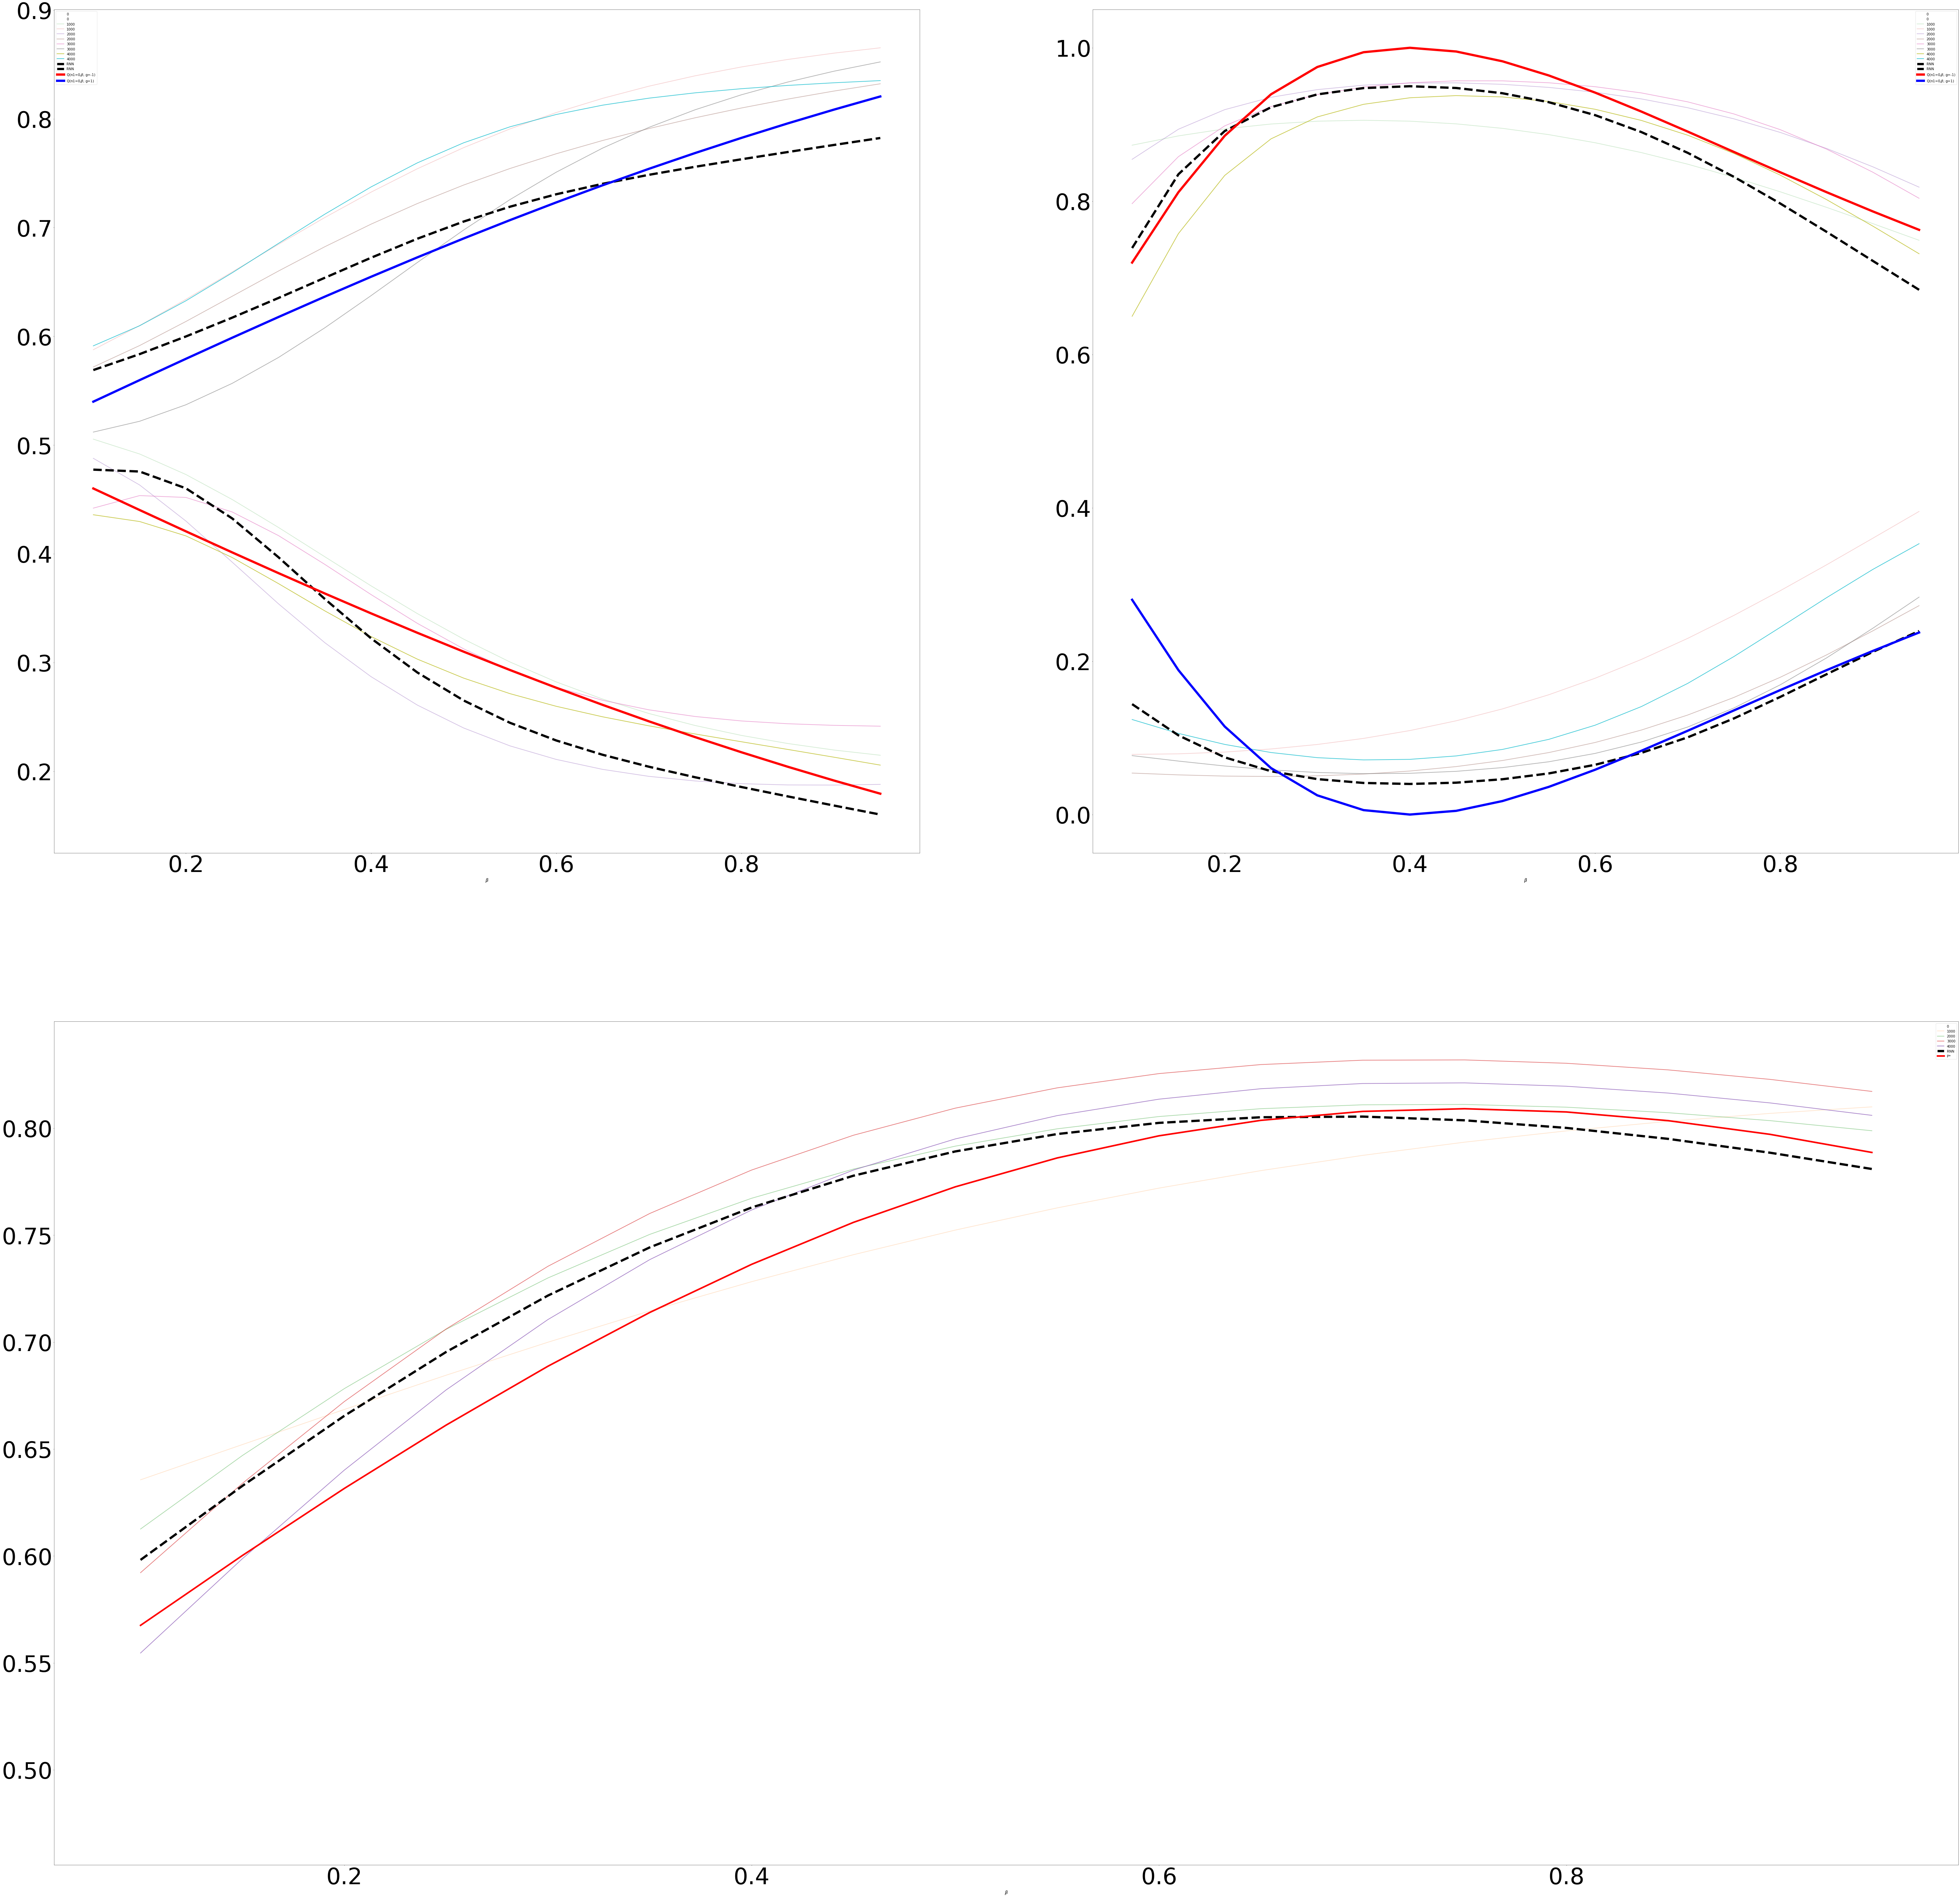

In [38]:
profiles_kennedy(critic, history_predictions,bbbs)

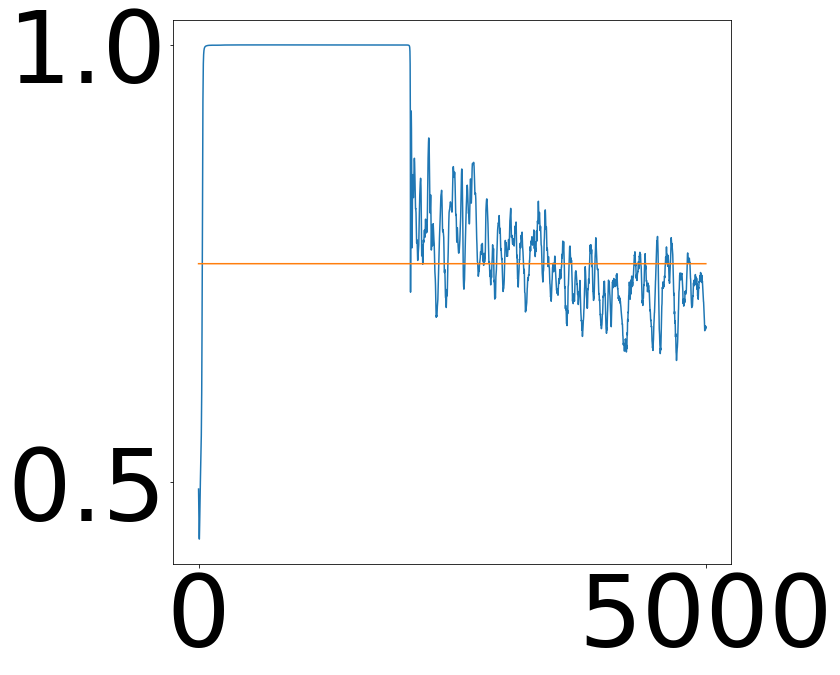

In [39]:
optimal_beta= 0.7499999999999993

plt.figure(figsize=(10,10))
plt.plot(betas_would)
plt.plot(np.ones(len(betas_would))*optimal_beta)

In [58]:
np.where(np.round(betas_would,1)==1)[0][-1]

2086

In [57]:
np.where(np.round(betas_would,1)==0.9)[0][-1]


2718

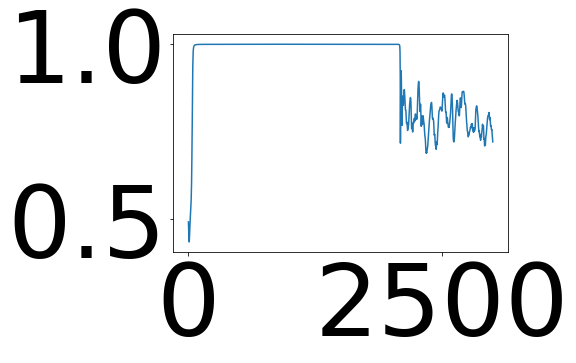

In [62]:
plt.plot(betas_would[0:3000])

In [66]:
def profiles_kennedy(critic, history_predictions, bbs):
    matplotlib.rc('font', serif='cm10')
    plt.rcParams.update({'font.size': 100})
    plt.figure(figsize=(150,150), dpi=50)


    ax1 = plt.subplot2grid((2,2),(0,0))
    ax2 = plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
    #betas = np.arange(.1,1.1,.05)
    betas = bbs
    if history_predictions!=False:
        axs = {"0":ax1, "1":ax2}
        for ind, epi in enumerate(history_predictions.keys()):
            if epi != "final_episode_info":

                transp_epi = float(epi)/history_predictions["final_episode_info"]
                ax3.plot(betas,history_predictions[epi]["[]"] , alpha=transp_epi, linewidth=3,label=str(epi))
                for outcome in [0.,1.]:
                   for guess_index in [0.,1.]:
                       axs[str(int(outcome))].plot(betas, history_predictions[epi][str(outcome)+str(guess_index)] , alpha=0.7, linewidth=3,label=str(epi))#+"-g:"+str((-1)**guess_index))



    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), '--', color="black", linewidth=10,label="RNN")

    axes = {"0.0":ax1, "1.0":ax2}
    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], '--', color="black", linewidth=10,label="RNN")


    ax1.plot(betas,[misc.qval(b, 0, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[misc.qval(b, 0, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[misc.qval(b, 1, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[misc.qval(b, 1, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,misc.ps_maxlik(betas), linewidth=7, color="red", label="P*")

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":45})



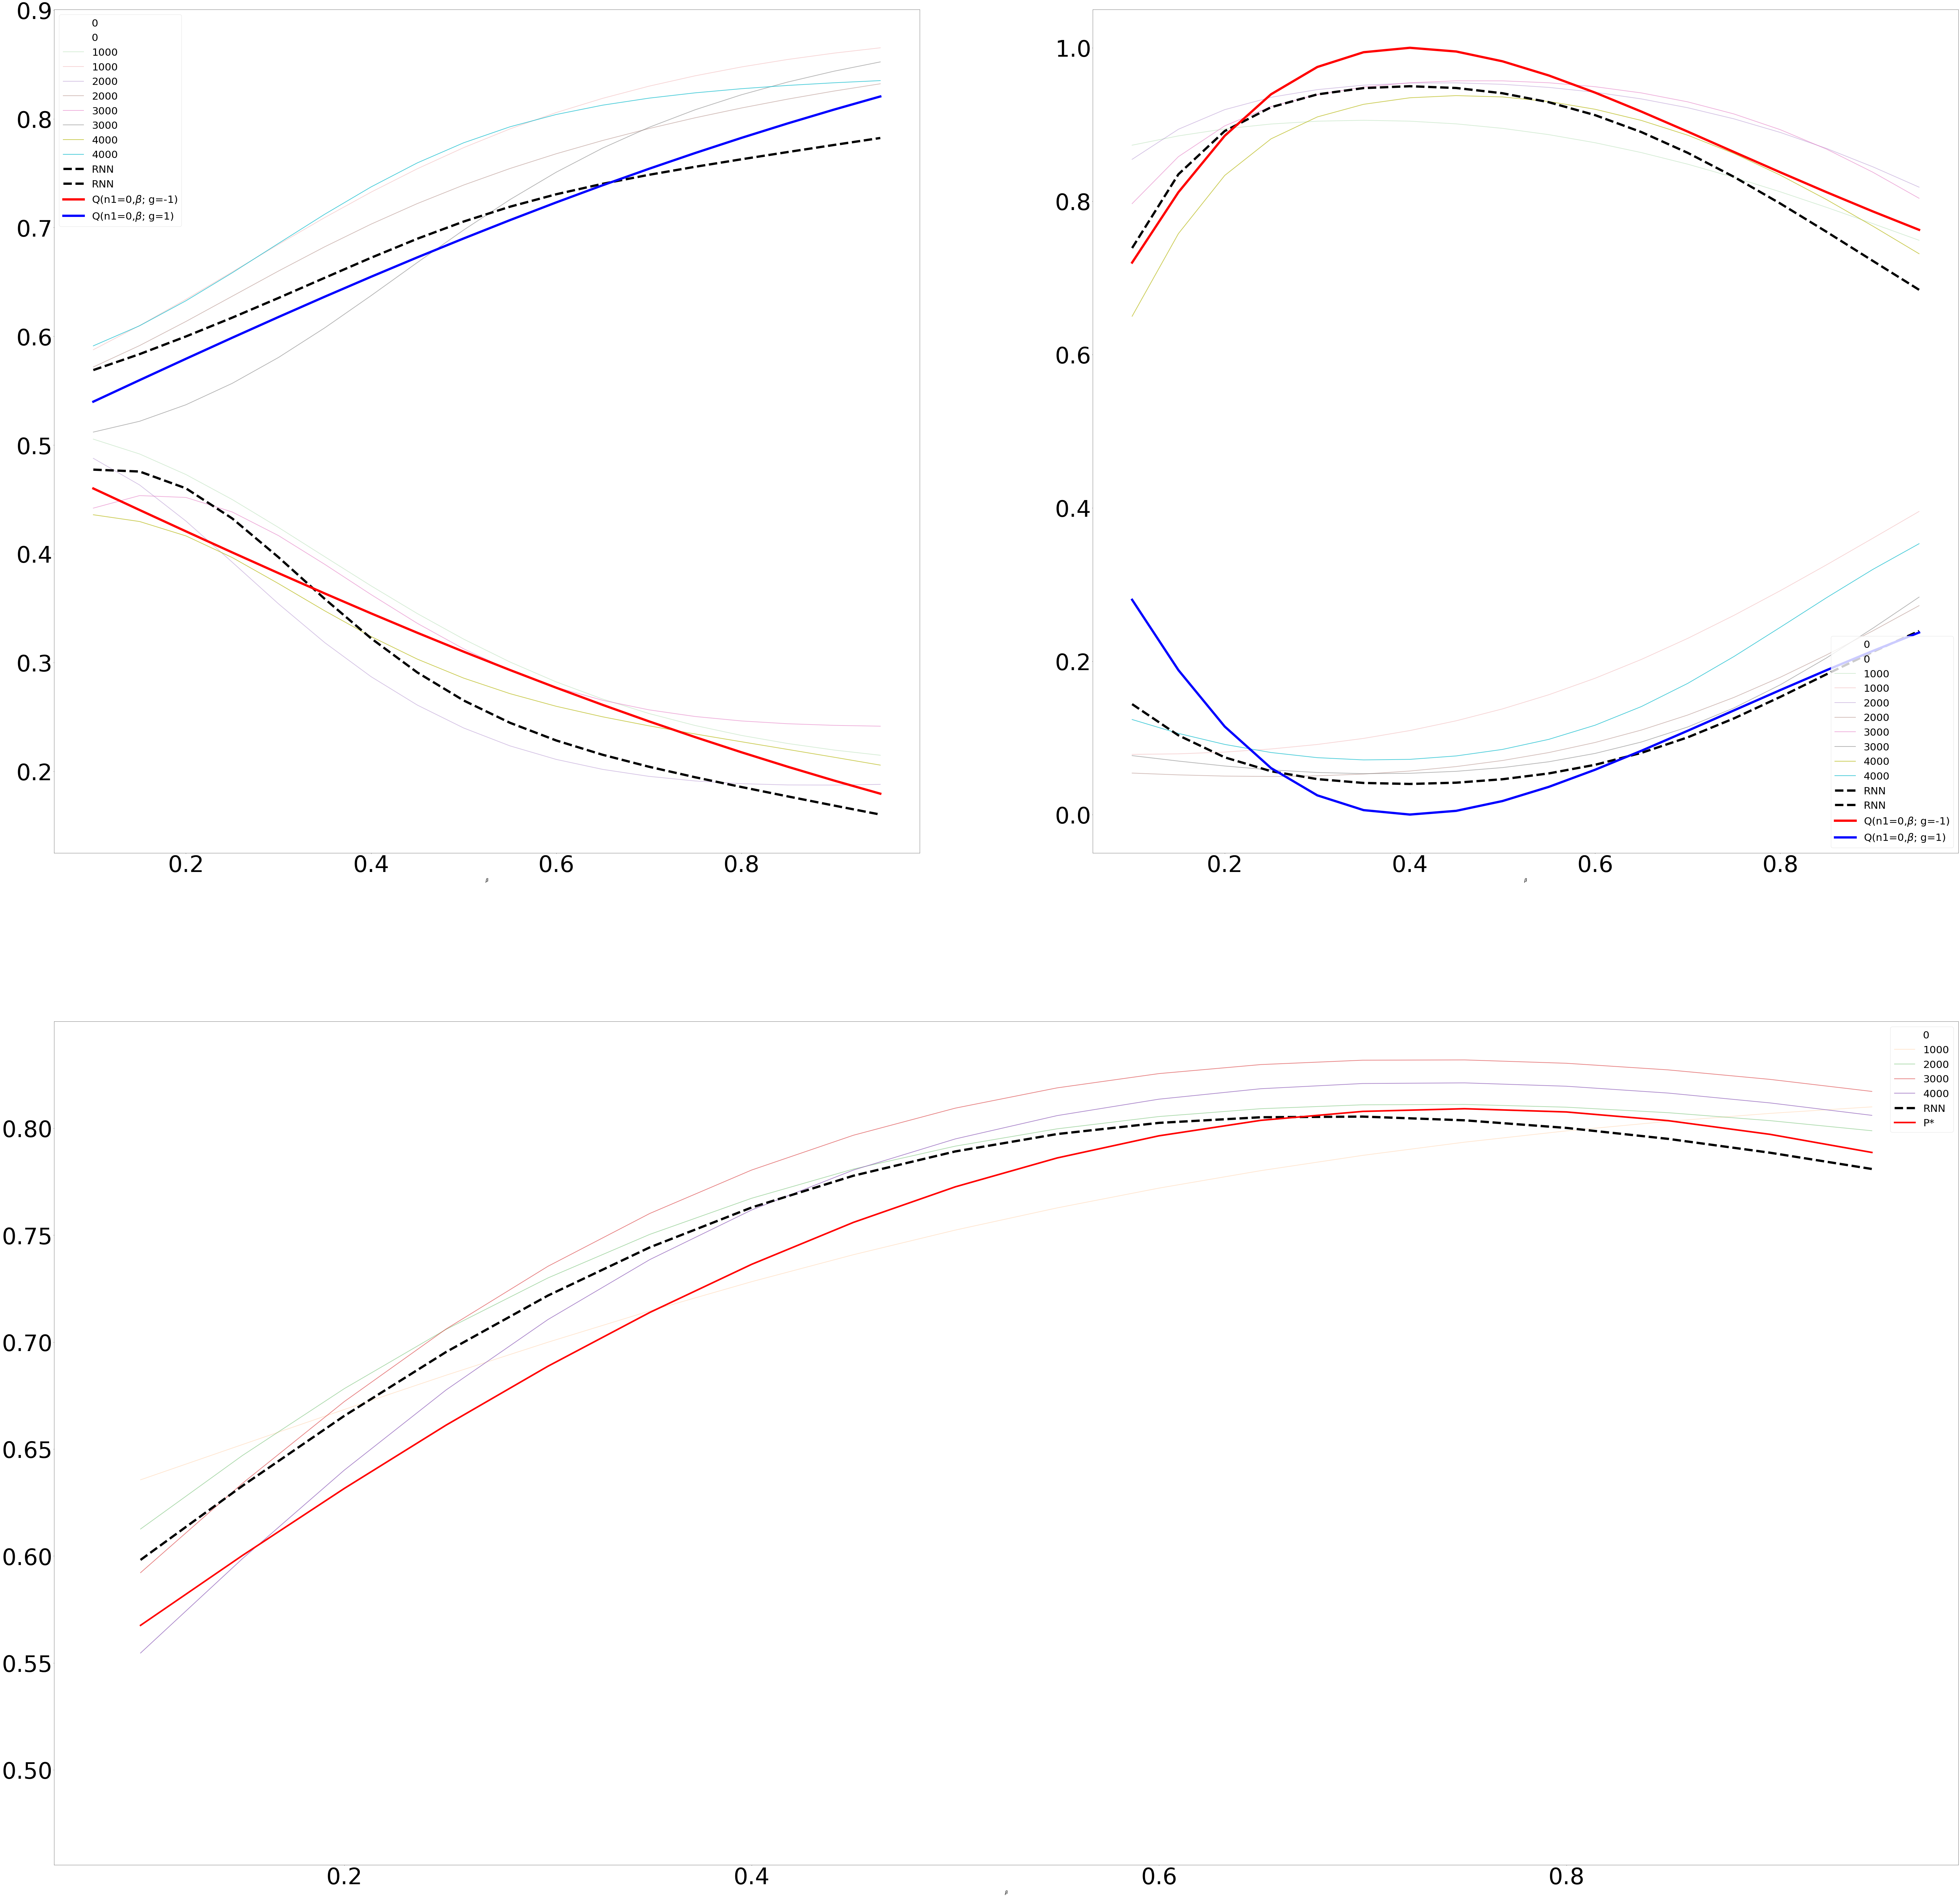

In [68]:
profiles_kennedy(critic, history_predictions, bbbs)